In [1]:
# importing baseline packages
import os

# importing data processing packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# importing machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# importing visualisation libraries
import matplotlib.pyplot as plt
plt.style.use('../conf/custom_mpl_stylesheet.mplstyle')

# import custom classes
from custom_utils import DataPrepUtil

In [2]:
drop_cols = ['Id', 'SalePrice']
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
X_train, X_val, y_train, y_val = train_test_split(train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice'], test_size=0.2, random_state=43)

In [3]:
datautil = DataPrepUtil()

In [4]:
missing_val_cols = [var for var in train.columns if train[var].isna().sum() > 0]
train[missing_val_cols]

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,NaN,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,NaN,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,NaN,NaN,0.0,Gd,TA,No,Unf,Unf,SBrkr,TA,Attchd,1999.0,RFn,TA,TA,NaN,NaN,NaN
1456,85.0,NaN,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,TA,Attchd,1978.0,Unf,TA,TA,NaN,MnPrv,NaN
1457,66.0,NaN,NaN,0.0,TA,Gd,No,GLQ,Unf,SBrkr,Gd,Attchd,1941.0,RFn,TA,TA,NaN,GdPrv,Shed
1458,68.0,NaN,NaN,0.0,TA,TA,Mn,GLQ,Rec,FuseA,NaN,Attchd,1950.0,Unf,TA,TA,NaN,NaN,NaN


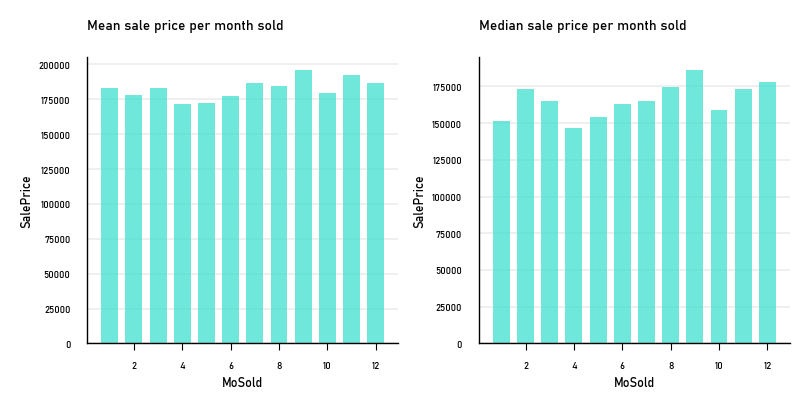

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100)
axes[0].bar(train.groupby('MoSold')['SalePrice'].mean().index, train.groupby('MoSold')['SalePrice'].mean(), color='turquoise', width=0.7, alpha=0.75)
axes[0].set_xlabel('MoSold')
axes[0].set_ylabel('SalePrice')
axes[0].set_title('Mean sale price per month sold')
axes[1].bar(train.groupby('MoSold')['SalePrice'].median().index, train.groupby('MoSold')['SalePrice'].median(),  color='turquoise', width=0.7, alpha=0.75)
axes[1].set_xlabel('MoSold')
axes[1].set_ylabel('SalePrice')
axes[1].set_title('Median sale price per month sold')

plt.tight_layout()
plt.show()

2024-03-06 15:50:46 - INFO - plot_filled_values_percent - START ...


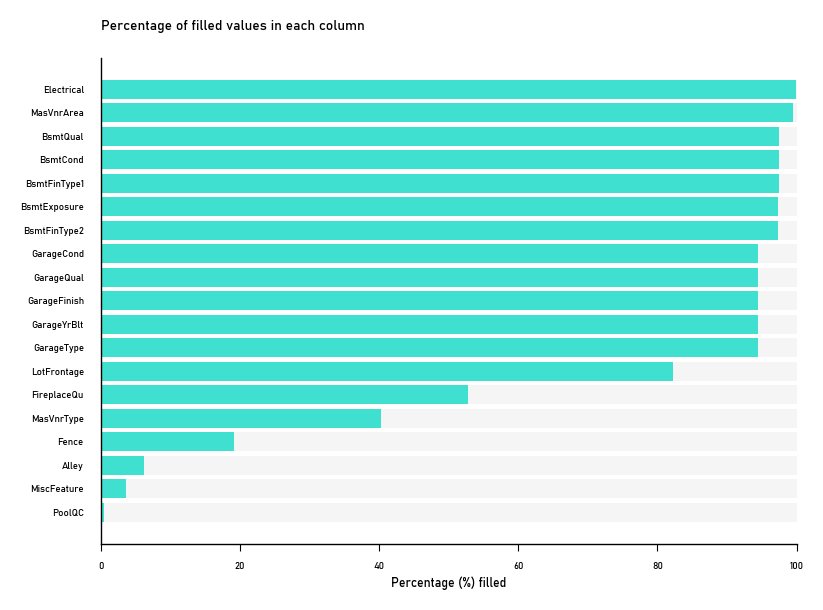

2024-03-06 15:50:46 - INFO - plot_filled_values_percent - ... FINISH


In [6]:
datautil.plot_filled_values_percent(train[missing_val_cols], dpi=100)

In [7]:
# list of categorical variables
cat_cols = [var for var in train.columns if train[var].dtype == 'O']

# list of the non-categorical variables
non_cat_cols = [var for var in train.columns if train[var].dtype !='O']

# list of variables that contain date & time information
dt_cols = [var for var in train.columns if 'Yr' in var or 'Year' in var]

# discrete numerical variables (i.e., numerical variables with a finite small set of distinct values (<20)
disc_cols = [var for var in non_cat_cols if train[var].nunique() < 25 and var not in dt_cols]

# list of numerical variables
num_cols = [var for var in non_cat_cols if var not in disc_cols and var not in drop_cols]

In [8]:
disc_cols.sort()

In [9]:
cardinality = train[cat_cols].nunique()
train[cardinality.index[0]].count()

1460

2024-03-06 15:50:46 - INFO - plot_cat_col_cardinality - START ...


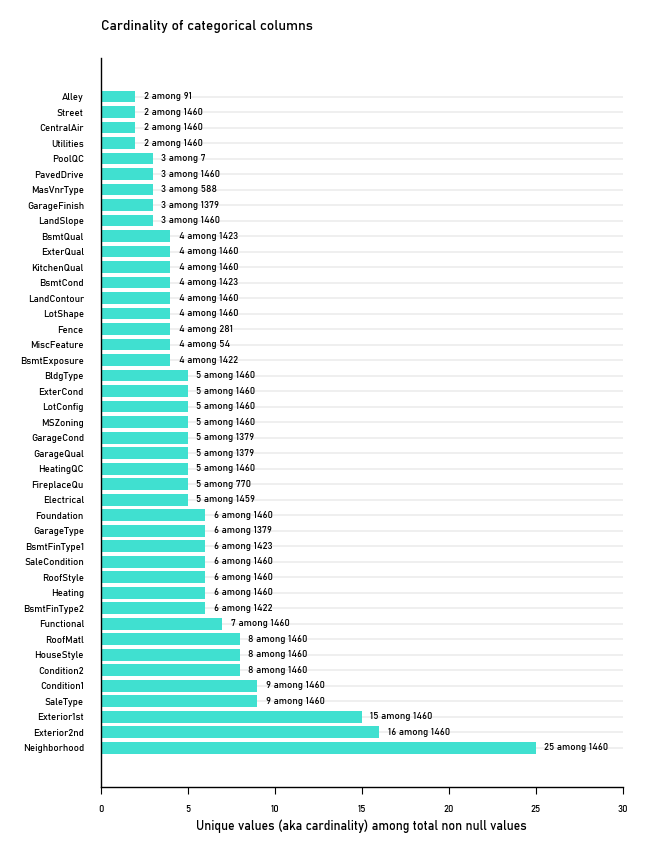

2024-03-06 15:50:47 - INFO - plot_cat_col_cardinality - ... FINISH


In [10]:
datautil.plot_cat_col_cardinality(train[cat_cols], dpi=100)

## Data Imputation

In [11]:
X_train[disc_cols] = X_train[disc_cols].astype('O')
X_val[disc_cols] = X_val[disc_cols].astype('O')

In [25]:
num_imputer = Pipeline(
    steps=[
    ('num_imputer', SimpleImputer(strategy='mean'))
    ]
)

cat_imputer = Pipeline(
    steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent'))
    ]
)

col_transformer = ColumnTransformer(
    transformers=[
        ('num_imputer', num_imputer, num_cols),
        ('cat_imputer', cat_imputer, cat_cols + disc_cols)
    ],
    remainder='passthrough'
)

feat_engg_pipeline = Pipeline(
    steps=[
        ('transform', col_transformer)
    ]
)

X_train_transformed = feat_engg_pipeline.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)
